In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
PATH = Path('/home/jupyter/fastai/courses/dl2/data/pascal')
JPEG_PATH = PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'

In [3]:
trn_j = json.load((PATH/'pascal_train2007.json').open())

In [4]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
cats = {o['id']:o['name'] for o in trn_j['categories']}
trn_fns = {o['id']:o['file_name'] for o in trn_j['images']}
trn_ids = [o['id'] for o in trn_j['images']]

In [6]:
list(JPEG_PATH.iterdir())[:5]

[PosixPath('/home/jupyter/fastai/courses/dl2/data/pascal/VOCdevkit/VOC2007/JPEGImages/004088.jpg'),
 PosixPath('/home/jupyter/fastai/courses/dl2/data/pascal/VOCdevkit/VOC2007/JPEGImages/003771.jpg'),
 PosixPath('/home/jupyter/fastai/courses/dl2/data/pascal/VOCdevkit/VOC2007/JPEGImages/008495.jpg'),
 PosixPath('/home/jupyter/fastai/courses/dl2/data/pascal/VOCdevkit/VOC2007/JPEGImages/004702.jpg'),
 PosixPath('/home/jupyter/fastai/courses/dl2/data/pascal/VOCdevkit/VOC2007/JPEGImages/005115.jpg')]

In [7]:
im0_d = trn_j['images'][0]
im0_d['file_name'], im0_d['id']

('000012.jpg', 12)

In [8]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [9]:
trn_anno = collections.defaultdict(list)
for o in trn_j['annotations']:
    if not o['ignore']:
        trn_anno[o['image_id']].append((hw_bb(o['bbox']), o['category_id']))

In [10]:
len(trn_anno), len(cats)

(2501, 20)

### Look at some example from the data

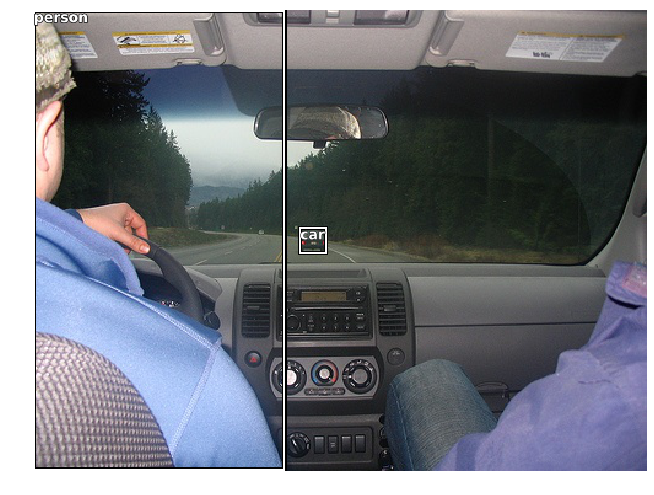

In [11]:
i = trn_ids[811]
img = open_image(JPEG_PATH/trn_fns[i])
bboxes = [o[0] for o in trn_anno[i]]
classes = [cats[o[1]] for o in trn_anno[i]]
labels = range(len(classes))
labels, classes
bbox = ImageBBox.create(*img.size, bboxes=bboxes, classes=classes, labels=labels)
img.show(y=bbox, figsize=(11, 11))

# Largest Item Classifier

In [12]:
def get_lrg(b):
    if not b: raise Exception()
    return max(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]))

In [13]:
trn_lrg_anno = {a: [get_lrg(b)] for a, b in trn_anno.items()}

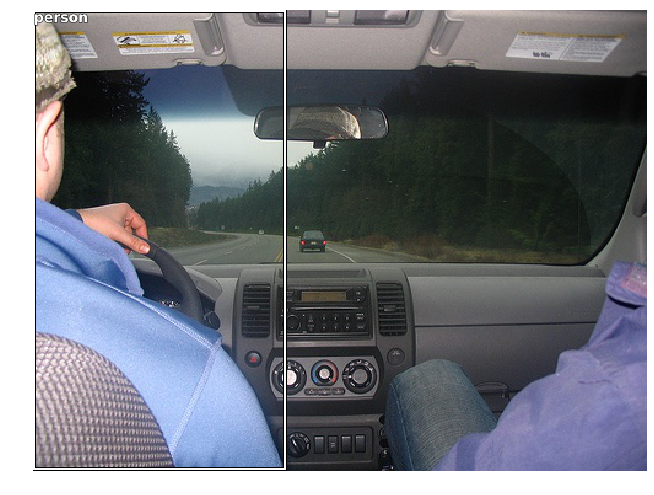

In [14]:
i = trn_ids[811]
img = open_image(JPEG_PATH/trn_fns[i])
bboxes = [o[0] for o in trn_lrg_anno[i]]
classes = [cats[o[1]] for o in trn_lrg_anno[i]]
labels = range(len(classes))
labels, classes
bbox = ImageBBox.create(*img.size, bboxes=bboxes, classes=classes, labels=labels)
img.show(y=bbox, figsize=(11, 11))

In [15]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [16]:
df = pd.DataFrame({'fn':[Path('VOCdevkit/VOC2007/JPEGImages')/trn_fns[i] for i in trn_ids],
                   'cat':[cats[trn_lrg_anno[i][0][1]] for i in trn_ids]}, columns=['fn', 'cat'])

In [43]:
np.random.seed(100)
ids = range(len(trn_ids))
ids = np.random.permutation(ids)
split = int(.2 * len(ids))
train_idx, valid_idx = ids[split:], ids[:split]
len(train_idx), len(valid_idx)

(2001, 500)

In [44]:
f_model = models.resnet34
sz = 224
bs = 64

In [58]:
src = (ImageList.from_df(path=PATH, df=df, cols='fn')
       .split_by_idxs(train_idx, valid_idx))

In [127]:
tfms = None #get_transforms()

In [128]:
def get_data(size, bs):
    return (src.label_from_df()
            .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH)
            .databunch(bs=bs).normalize(imagenet_stats))

In [249]:
data = get_data(size=sz, bs=bs)

**No data transforms at all**

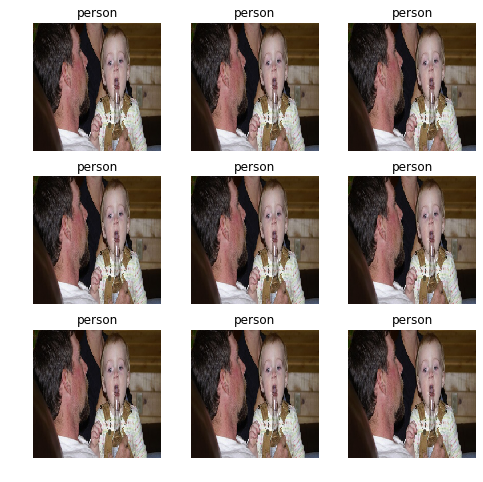

In [250]:
def _plot(i, j, ax):
    x, y = data.train_ds[171]
    x.show(ax, y=y)
    
plot_multi(_plot, r=3, c=3, figsize=(8, 8))

In [251]:
learn = cnn_learner(data, base_arch=f_model, metrics=[accuracy], bn_final=True)

In [252]:
learn.opt_func = optim.Adam

In [158]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


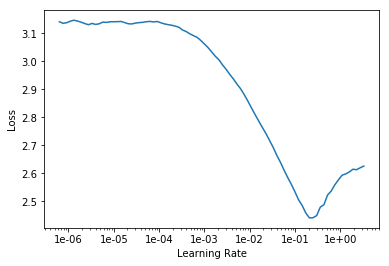

In [159]:
learn.recorder.plot()

In [160]:
lr = 1e-2

In [161]:
learn.fit_one_cycle(cyc_len=3, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.324892,1.262018,0.664000,00:10
1,1.765557,0.881449,0.766000,00:11
2,1.427139,0.957618,0.778000,00:11


In [162]:
learn.unfreeze()

In [163]:
learn.fit_one_cycle(cyc_len=2, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.084801,0.990065,0.784000,00:14
1,0.995446,1.037266,0.774000,00:14


In [164]:
data = get_data(352, bs)
learn.data = data

In [165]:
learn.fit_one_cycle(cyc_len=2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.907835,1.072842,0.794000,00:14
1,0.893630,1.099835,0.786000,00:14


In [166]:
learn.save('clas_one')

In [253]:
learn.load('clas_one');

RuntimeError: CUDA out of memory. Tried to allocate 9.00 MiB (GPU 0; 7.43 GiB total capacity; 6.79 GiB already allocated; 6.94 MiB free; 45.65 MiB cached)

In [247]:
learn.show_results(ds_type=DatasetType.Valid, rows=5)

RuntimeError: CUDA out of memory. Tried to allocate 36.75 MiB (GPU 0; 7.43 GiB total capacity; 6.70 GiB already allocated; 22.94 MiB free; 89.25 MiB cached)

In [248]:
gc.collect()

43